In [1]:

import os

import matplotlib.pyplot as plt
import pandas as pd

import clip as clip
import wandb


%reload_ext autoreload
%autoreload 2

# Data Loading

In [2]:
import torch

df = pd.read_csv("/Users/yonatanlou/dev/RabbinicWisdomAI/experiments/init/processed_data.csv")
df.info()
df = df.dropna()
df = df.rename(columns={"index": "label_index"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             137 non-null    int64 
 1   שם התשובה ומקורו  137 non-null    object
 2   question          137 non-null    object
 3   label             132 non-null    object
 4   answer            137 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.5+ KB


Text(0.5, 1.0, 'Histogram of answer length')

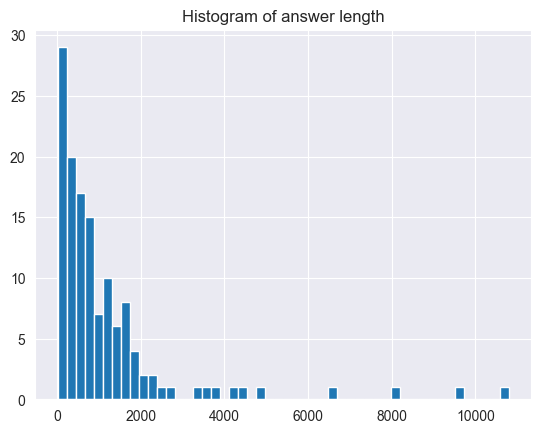

In [3]:
df["answer_length"] = df["answer"].str.split(" ").str.len()
df["answer_length"].hist(bins=50)
plt.title("Histogram of answer length")

In [4]:
import os
openai_api_key  = "yyy"
os.environ["OPENAI_API_KEY"] = openai_api_key
from openai import OpenAI
from tqdm.notebook import tqdm



# Define a function to get the GPT-4o-mini response
def get_rabbi_answer(question):
    prompt = f"You are a Jewish Rabbi who has a broad knowledge about all kinds of Jewish matters. I will ask you a question, and you will answer it. Please answer concisely, and your answer should be no longer than 600 words. Don't include any formatting to the text. Dont include new lines"
    client = OpenAI(
)
    try:
        # Use the new ChatCompletion API
        response = client.chat.completions.create(
            model="gpt-4o-mini",  # Use the correct model
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": question}
            ],
            max_tokens=600,  # Adjust token count to match the word limit (~600 words)
            temperature=0.7  # Adjust the temperature for more or less creative responses
        )
        # Extract the text of the generated answer
        answer = response.to_dict()["choices"][0]["message"]["content"].strip() 
        return answer
    except Exception as e:
        print(f"Error generating answer for question '{question}': {e}")
        return None


df['generated_answer'] = None

if not os.path.exists("questions_with_generated_answers.csv"):
    for idx, row in tqdm(df.iterrows()):
        question = row['question']
        generated_answer = get_rabbi_answer(question)
        print(f"{question=}")
        print(f"{generated_answer=}")
        print()
        df.at[idx, 'generated_answer'] = generated_answer
    df.to_csv('questions_with_generated_answers.csv', index=False)



df = pd.read_csv("questions_with_generated_answers.csv")

In [5]:
def simple_chunking(text, chunk_size=128, overlap=0):

    words = text.split()
    chunks = []

    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)

    return chunks


def get_embedding(answer: str, model, tokenizer,chunk_size=400,overlap=20, method="mean_last_hidden"):
    all_embeddings = []
    texts = simple_chunking(answer, chunk_size=chunk_size, overlap=overlap)

    for text in texts:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=tokenizer.model_max_length,
        )
        with torch.no_grad():
            outputs = model(**inputs)

        if method == "mean_last_hidden":
            embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        elif method == "cls_token":
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        elif method == "pooler_output":
            embedding = outputs.pooler_output.cpu().numpy()
        elif method == "mean_all_layers":
            all_layers = outputs.hidden_states
            mean_all_layers = torch.stack(all_layers).mean(dim=0)
            embedding = mean_all_layers.mean(dim=1).cpu().numpy()
        else:
            raise ValueError(f"Unknown method: {method}")

        all_embeddings.append(embedding)

    return np.vstack(all_embeddings).mean(axis=0)  #

In [6]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
import numpy as np
from tqdm.notebook import tqdm
model_name = 'dicta-il/BEREL'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
# Get embeddings for all answers and generated answers
import random
def set_seed_globally(seed=42):
    # Set seeds
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed_globally()
all_answers = df['answer'].tolist() + df['generated_answer'].tolist()
embeddings = []
for answer in tqdm(all_answers, desc="Getting embeddings"):
    embeddings.append(get_embedding(answer,model, tokenizer, chunk_size=300, overlap=30))



Some weights of BertModel were not initialized from the model checkpoint at dicta-il/BEREL and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Getting embeddings:   0%|          | 0/264 [00:00<?, ?it/s]

In [7]:
df["gen_answer_length"] = df["generated_answer"].str.split(" ").str.len()

In [8]:
all_embeddings_size = len(embeddings)

real_answers_embeddings = np.array(embeddings[:int(all_embeddings_size/2)])
generated_answers_embeddings = np.array(embeddings[int(all_embeddings_size/2):])

real_answers_embeddings_norm =np.linalg.norm(real_answers_embeddings, axis=1, keepdims=True) 
generated_answers_embeddings_norm =np.linalg.norm(generated_answers_embeddings, axis=1, keepdims=True)

real_answers_embeddings /= real_answers_embeddings_norm
generated_answers_embeddings /= generated_answers_embeddings_norm

print(f"{real_answers_embeddings.shape=}, {generated_answers_embeddings.shape=}")

real_answers_embeddings.shape=(132, 768), generated_answers_embeddings.shape=(132, 768)


In [9]:
similarity_submatrix = cosine_similarity(real_answers_embeddings,generated_answers_embeddings)

In [10]:
import numpy as np

from sklearn.metrics import accuracy_score
def knn_score(similarity_submatrix, k):

    predictions = []
    # Perform kNN for each row and check if the row index is among the top k neighbors
    for i in range(similarity_submatrix.shape[0]):
        row = similarity_submatrix[i, :]
    
        top_k = np.argsort(row)[-k:]  # Get indices of the top k values (ascending order)
    
        # Check if the row index itself (i) is in the top k neighbors
        if i in top_k:
            predictions.append(1)  # True prediction
        else:
            predictions.append(0)  # False prediction
    
    # Generate true labels (all ones, since each row should ideally predict itself)
    true_labels = np.ones(similarity_submatrix.shape[0])
    
    # Calculate accuracy score
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, predictions


def hungarian_score(similarity_submatrix):
    
    # Convert similarities to costs by subtracting from 1 (because the Hungarian algorithm finds minimum cost)
    cost_matrix = 1 - similarity_submatrix
    
    # Perform matching using the Hungarian algorithm
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    accuracy = (row_indices == col_indices).mean()
    return accuracy, col_indices
def evaluate_model_argmax(q_features, a_features):
    # Normalize embeddings
    q_features = q_features / np.linalg.norm(q_features, axis=-1, keepdims=True)
    a_features = a_features / np.linalg.norm(a_features, axis=-1, keepdims=True)

    # Compute cosine similarity matrix using sklearn's cosine_similarity
    similarity_submatrix = cosine_similarity(q_features, a_features)

    # Evaluate argmax-based accuracy
    true_labels = np.arange(similarity_submatrix.shape[0])
    predicted_labels = np.argmax(similarity_submatrix, axis=1)
    
    return accuracy_score(true_labels, predicted_labels)


In [12]:
accuracy_hung, prediction_hung = hungarian_score(similarity_submatrix)
accuracy_knn1, prediction_knn = knn_score(similarity_submatrix, 1)
accuracy_knn2, prediction_knn = knn_score(similarity_submatrix, 2)
accuracy_knn3, prediction_knn = knn_score(similarity_submatrix, 3)
accuracy_knn5, prediction_knn = knn_score(similarity_submatrix, 5)
accuracy_argmax = evaluate_model_argmax(real_answers_embeddings,generated_answers_embeddings)
print(f"{accuracy_hung=}")
print(f"{accuracy_knn1=:.2f}, {accuracy_knn2=:.2f}, {accuracy_knn3=:.2f}, {accuracy_knn5=:.2f}")
print(f"{accuracy_argmax=}")

accuracy_hung=0.6590909090909091
accuracy_knn1=0.25, accuracy_knn2=0.39, accuracy_knn3=0.47, accuracy_knn5=0.54
accuracy_argmax=0.25
